In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess the MNIST dataset
mnist_dataset, mnist_info = tfds.load('mnist', with_info=True, as_supervised=True)
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']


In [ ]:
# Normalize the pixel values to [0, 1]
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.
    return image, image  # Denoising task: ground truth is the noisy image itself

mnist_train = mnist_train.map(normalize_img)
mnist_test = mnist_test.map(normalize_img)

# Add noise to the training and test data
noise_factor = 0.2
def add_noise(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_factor)
    noisy_image = image + noise
    return noisy_image, image  # Denoising task: ground truth is the clean image

noisy_train = mnist_train.map(add_noise)
noisy_test = mnist_test.map(add_noise)

In [ ]:
# Define the autoencoder model with increased complexity
class DenoisingAutoencoder(tf.keras.Model):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(28*28, activation='sigmoid'),
            tf.keras.layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create an instance of the model
autoencoder = DenoisingAutoencoder()

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
batch_size = 32
epochs = 10
autoencoder.fit(noisy_train.batch(batch_size), epochs=epochs, validation_data=noisy_test.batch(batch_size))


Epoch 1/10
1875/1875 [==============================] - 17s 8ms/step - loss: 0.0259 - val_loss: 0.0150
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0136 - val_loss: 0.0120
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 7/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 8/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - l

In [ ]:
# Evaluate the model
autoencoder.evaluate(noisy_test.batch(batch_size))

313/313 [==============================] - 1s 4ms/step - loss: 0.0077


0.007717644330114126

1/1 [==============================] - 0s 52ms/step


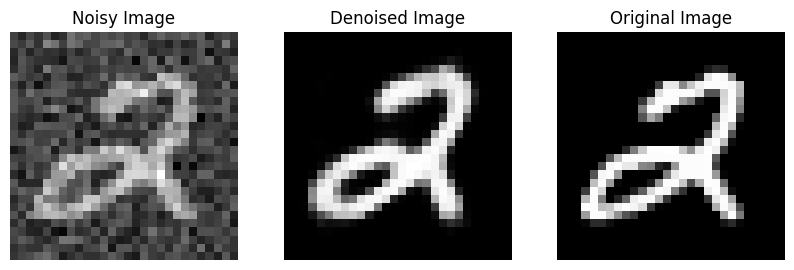

1/1 [==============================] - 0s 27ms/step


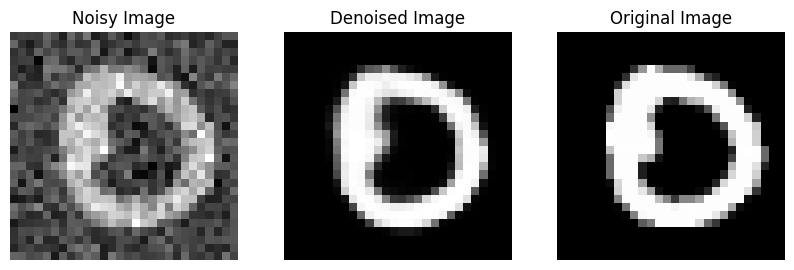

1/1 [==============================] - 0s 119ms/step


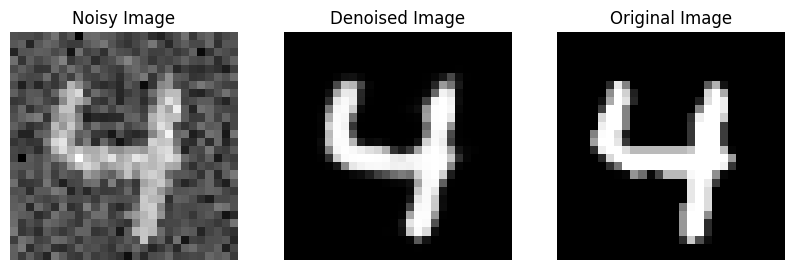

1/1 [==============================] - 0s 29ms/step


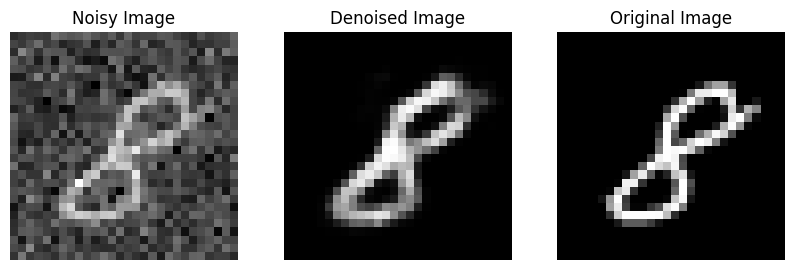

1/1 [==============================] - 0s 25ms/step


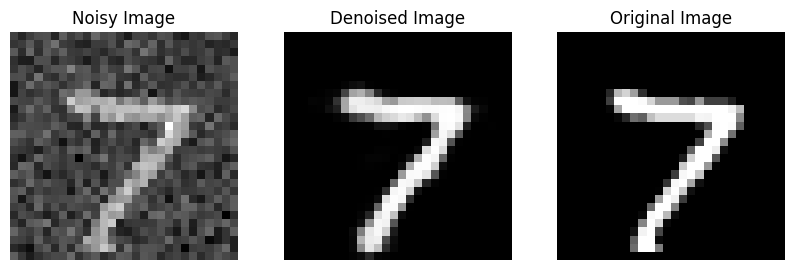

In [ ]:
# Visualize a few denoised images
num_images = 5
for noisy_img, clean_img in noisy_test.take(num_images):
    denoised_img = autoencoder.predict(tf.expand_dims(noisy_img, axis=0))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_img.numpy().squeeze(), cmap='gray')
    plt.title('Noisy Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(denoised_img.squeeze(), cmap='gray')
    plt.title('Denoised Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(clean_img.numpy().squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.show()